Regression at kahiltna site KPS using MERRA2 precip and MERRA2 temperature data: 
kp = 2.4702316430216373


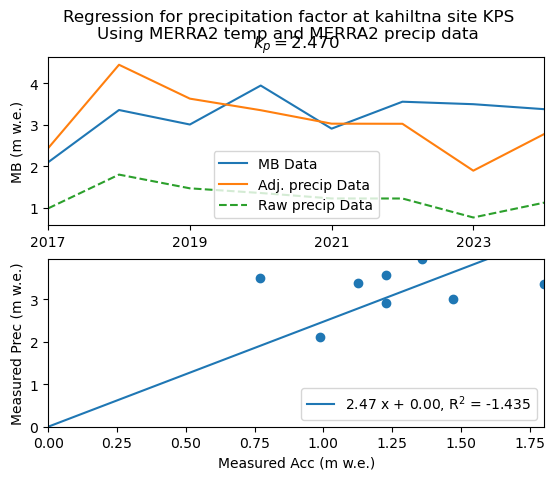

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import os
import argparse

# INPUTS
glac_no = '01.22193'            # 09162 WOLV 22193 KAH
site = 'KPS'                      # Name of index site
region = glac_no[:2]
temp_dataset = 'MERRA2'         # MERRA2 or AWS
tp_dataset = 'MERRA2'           # MERRA2 or AWS
AWS_elev = 990
temp_threshold = [0.2,2.2]      # Threshold to linearly scale rain/snow

# COMMAND LINE ARGS
parser = argparse.ArgumentParser(description='kp regressor arguments')
parser.add_argument('-site', action='store', default=site)
parser.add_argument('-glac_no', action='store', default=glac_no)
parser.add_argument('-temp_dataset', action='store', default=temp_dataset)
parser.add_argument('-tp_dataset', action='store', default=tp_dataset)
parser.add_argument('-store_kp', action='store_true')
parser.add_argument('-f', '--fff', help='Dummy arg to fool ipython', default='1')
args = parser.parse_args()
glacier = 'wolverine' if args.site == 'EC' else 'gulkana'
glacier = 'kahiltna' if args.site == 'KPS' else glacier

# FILEPATHS
fp_clim = 'C:/users/cvw30/Research/Model/climate_data/'
fp_MERRA2 = os.path.join(fp_clim,f'MERRA2/VAR/MERRA2_VAR_{glacier}_alltime.nc')
fp_ERA5 = os.path.join(fp_clim,'ERA5/ERA5_hourly/ERA5_VAR_hourly.nc')
fp_AWS = os.path.join(fp_clim,f'AWS/Raw/Benchmark/{glacier.capitalize()}/LVL2/{glacier}{AWS_elev}_hourly_LVL2.csv')
list_RGI = os.listdir(fp_clim + '../RGI/rgi60/00_rgi60_attribs/')
for file in list_RGI:
    if region in file:
        fp_RGI = fp_clim + '../RGI/rgi60/00_rgi60_attribs/' + file
fp_MERRA2_constants = fp_clim + '/MERRA2/MERRA2constants.nc4'
fp_ERA5_constants = fp_clim + '/ERA5/ERA5_hourly/ERA5_geopotential.nc'
fp_MB = fp_clim + f'../MB_data/{glacier.capitalize()}/Input_{glacier.capitalize()}_Glaciological_Data.csv'
# fp_bias = '/home/claire/research/PyGEM-EB/pygem_eb/sample_data/Gulkana/Gulkana_MERRA2_temp_bias.csv'
fp_sites = fp_clim + f'../PEBSI/data/by_glacier/{glacier}/site_constants.csv'

# NECESSARY INFO
include_intercept = False                       # if False, force y-intercept to be 0
all_vars = {'temp':{'MERRA2':'T2M','ERA5':'t2m'},
            'tp':{'MERRA2':'PRECTOTCORR','ERA5':'tp'}}
LAPSE_RATE = -0.0065

# FIND LAT LON OF GLACIER CENTERPOINT
glacier_table = pd.read_csv(fp_RGI)
glacier_table = glacier_table.loc[glacier_table['RGIId'] == 'RGI60-'+args.glac_no]
cenlat = glacier_table['CenLat'].to_numpy()[0]
cenlon = glacier_table['CenLon'].to_numpy()[0]

# TEMPERATURE THRESHOLD FOR INTERPOLATION
rain_scale = np.linspace(0,1,20)
temp_scale = np.linspace(temp_threshold[0],temp_threshold[1],20)

# DEFINE FUNCTION TO SELECT DATASET
def get_reanalysis_df(reanalysis,var):
    """
    Selects the closest latitude and longitude gridcell
    from a dataset to the input cenlat, cenlon coordinates.
    Also returns the geopotential of that gridcell converted
    to elevation units (m)
    """
    # open dataset
    if reanalysis in ['MERRA2']:
        file_lat = str(int(np.floor(cenlat/10)*10))
        file_lon = str(int(np.floor(cenlon/10)*10))
        fn_MERRA2 = fp_MERRA2.replace('LAT',file_lat).replace('LON',file_lon)
        fn_MERRA2 = fn_MERRA2.replace('VAR',all_vars[var]['MERRA2'])
        ds = xr.open_dataset(fn_MERRA2)
        eds = xr.open_dataset(fp_MERRA2_constants)
        latname = 'lat'
        lonname = 'lon'
        elevname = 'PHIS'
    if reanalysis in ['ERA5']:
        fn_ERA5 = fp_ERA5.replace('VAR',var)
        ds = xr.open_dataset(fn_ERA5)
        eds = xr.open_dataset(fp_ERA5_constants)
        latname = 'latitude'
        lonname = 'longitude'
        elevname = 'z'

    # get latitude and longitude of nearest dataset point
    datalat = [ds.coords[latname].values]
    datalon = [ds.coords[lonname].values]
    lat_nearidx = np.abs(cenlat - datalat).argmin()
    lon_nearidx = np.abs(cenlon - datalon).argmin()
    lat = datalat[lat_nearidx]
    lon = datalon[lon_nearidx]

    if reanalysis == 'ERA5':
        lat = lat.round(2)
        lon = lon.round(2)
        if var == 'tcc':
            lat = lat.round(1)
            lon = lon.round(1)

    # select dataset by closest lat/lon to glacier center
    ds = ds # .sel({latname:lat,lonname:lon}).drop_vars([latname,lonname])
    ds = ds.interp(time = ds.time.values[:-1] + pd.Timedelta(minutes=30))
    eds = eds.sel({latname:lat,lonname:lon})
    elev = eds[elevname].to_numpy()[0] / 9.81

    df = ds.to_dataframe()
    df = df.rename(columns={all_vars[var][reanalysis]:var})
    df['Month'] = pd.to_datetime(df.index).month
    if var == 'temp':
        # units
        df['temp'] -= 273.15 # K -> C
        # deal with temperature bias
        bias_fp =f'C:/users/cvw30/Research/Model/PEBSI/data/bias_adjustment/quantile_mapping_{glacier}_temp.csv'
        bias_df = pd.read_csv(bias_fp)
        
        # interpolate values according to quantile mapping
        values = df['temp'].values
        adjusted = np.interp(values, bias_df['sorted'], bias_df['mapping'])
        df['temp'] = adjusted
    elif var == 'tp':
        df['tp'] *=  3600 / 1000 # kg m-2 s-1 -> m
    df['Year'] = pd.to_datetime(df.index).year
    return df,elev

def get_AWS_df(var):
    df = pd.read_csv(fp_AWS)
    df = df.set_index(pd.to_datetime(df['local_time']))
    if 'Precip_Weighing_Incremental' in df.columns:
        df.fillna({'Precip_Weighing_Incremental':df['Precip_Stage_Incremental']*1.48},inplace=True)
        df = df.rename(columns={'site_temp_USGS':'temp','Precip_Weighing_Incremental':'tp'})
    drop_columns = df.columns.to_list()
    drop_columns.remove('temp')
    drop_columns.remove('tp')
    df = df.drop(columns=drop_columns)
    if var == 'temp':
        if np.max(df[var]) > 100:
            df['temp'] -= 273.15 # K -> C
    if var == 'tp':
        df['tp'] /= 1000 # mm -> m
    df['Year'] = pd.to_datetime(df.index).year
    return df

# LOAD MASS BALANCE DATA
df_mb = pd.read_csv(fp_MB)
df_mb = df_mb.loc[df_mb['site_name'] == args.site]
# get years of mass balance data
years_mb = np.unique(df_mb['Year'])
if 2011 in years_mb:
    site_elev = df_mb.loc[df_mb['Year']==2011,'elevation'].values[0]
else:
    site_elev = df_mb.iloc[0]['elevation']
# chose 2011 because sites A, AB, B, D all measured

# LOAD CLIMATE DATA
# temp data
if args.temp_dataset != 'AWS':
    df_temp,data_elev = get_reanalysis_df(args.temp_dataset,'temp')
else:
    df_temp = get_AWS_df('temp')
    data_elev = AWS_elev

# tp data
if args.tp_dataset != 'AWS':
    df_tp,data_elev = get_reanalysis_df(args.tp_dataset,'tp')
else:
    df_tp = get_AWS_df('tp')
    data_elev = AWS_elev
# get years of climate data
years_clim = list(set(df_temp['Year']) & set(df_tp['Year']))

# adjust temperature by lapserate
df_temp['temp'] += (LAPSE_RATE)*(site_elev - data_elev)

# get intersecting years
years = np.array(list(set(years_mb) & set(years_clim)))
years = np.sort(years)[1:]
years = years[years > 2000]

# index MB data by years
winter_cum = df_mb['bw'].loc[df_mb['Year'].isin(years)]
winter_abl = df_mb['winter_ablation'].loc[df_mb['Year'].isin(years)]
winter_abl[np.isnan(winter_abl)] = 0
winter_mb_data = winter_cum - winter_abl

# ANNUAL ACCUMULATION FROM PRECIP DATA
tp_measured = []
for year in years:
    # get dates of accumulation (between fall and spring field dates)
    previous_fall_date = df_mb.loc[df_mb['Year']==year-1]['fall_date'].to_numpy()[0]
    if str(previous_fall_date) == 'nan':
        previous_fall_date = str(year-1) + '-08-10 00:00'
    spring_date = df_mb.loc[df_mb['Year']==year]['spring_date'].to_numpy()[0]
    if str(spring_date) == 'nan':
        spring_date = str(year) + '-04-20 00:00'
    acc_dates = pd.date_range(previous_fall_date,spring_date,freq='h')

    # select days with mean temp below 0
    cumulative_snowfall = 0
    for hour in acc_dates:
        temp = df_temp.loc[hour,'temp']
        tp = df_tp.loc[hour,'tp']
        if np.isnan(tp):
            tp = 0
        if temp < temp_threshold[1]:
            fraction_rain = np.interp(temp,temp_scale,rain_scale)
            cumulative_snowfall += tp * (1-fraction_rain)
    
    # store accumulation
    tp_measured.append(cumulative_snowfall)
tp_measured = np.array(tp_measured)

# filter out summers with no data
winter_mb_data = winter_mb_data.values
for data in [tp_measured,winter_mb_data]:
    with_data = np.where(data > 1e-3)
    years = years[with_data]
    tp_measured = tp_measured[with_data]
    winter_mb_data = winter_mb_data[with_data]

# REGRESSION
if include_intercept:
    X = np.vstack([tp_measured,np.ones(len(tp_measured))]).T
    y = winter_mb_data
    result,resid = np.linalg.lstsq(X,y,rcond=None)[:2]
    slope = result[0]
    intercept = result[1]
else:
    X = tp_measured.reshape(-1,1)
    y = winter_mb_data
    result,resid = np.linalg.lstsq(X,y,rcond=None)[:2]
    slope = result[0]
    intercept = 0
R2 = 1 - resid[0] / (y.size * y.var())
print(f'Regression at {glacier} site {args.site} using {args.tp_dataset} precip and {args.temp_dataset} temperature data: \nkp = {slope}')

# STORE VALUE
if args.store_kp:
    df = pd.read_csv(fp_sites,index_col=0)
    df.loc[args.site,'kp'] = slope
    df.to_csv(fp_sites)
    print(f'Stored to {fp_sites}')

# PLOT RESULTS
fig,ax = plt.subplots(2)
ax[0].plot(years,winter_mb_data,label='MB Data')
ax[0].plot(years,tp_measured * slope + intercept,label='Adj. precip Data')
ax[0].plot(years,tp_measured,'--',label='Raw precip Data')
ax[0].legend()
ax[0].set_xlim(years[0],years[-1])
ax[0].set_xticks(np.arange(years[0],years[-1],2))
ax[0].set_ylabel('MB (m w.e.)')

ax[1].scatter(tp_measured,winter_mb_data)
x = np.arange(0,np.max(tp_measured)+0.5,.05)
line_label = f'{slope:.2f} x + {intercept:.2f}, R$^2$ = {R2:.3f}'
ax[1].plot(x, x*slope+intercept,label=line_label)
ax[1].legend()
ax[1].set_xlabel('Measured Acc (m w.e.)')
ax[1].set_ylabel('Measured Prec (m w.e.)')
ax[1].set_xlim(0,np.max(X))
ax[1].set_ylim(0,np.max(y))

title = f'Regression for precipitation factor at {glacier} site {args.site}'
title += f'\nUsing {args.temp_dataset} temp and {args.tp_dataset} precip data'
fig.suptitle(title)
ax[0].set_title(f'$k_p = {slope:.3f}$')
# plt.savefig(f'/home/claire/research/climate_data/kp_tp{args.tp_dataset}_temp{args.temp_dataset}_{args.site}.png')
plt.show()